In [2]:
import hashlib

import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

def get_hash(num):
    return hashlib.md5(str(num).encode()).hexdigest()

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

loading the training and test data.

In [3]:
# RUN THIS  - DON'T COMMENT THIS OUT - it is needed for the autograder.

with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

This dataset is split into a training/validation set and a testing set. Importantly, the test set does not contain values for our target variable, `Sale Price`. In this project, I am training a model on the training/validation set then using this model to predict the `Sale Price`s of the test set. 

In [4]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [5]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)
# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)
# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

Let's remind ourselves of the data available to us in the Cook County dataset. Remember, a more detailed description of each variable is included in `codebook.txt`, which is in the same directory as this notebook). **If you did not attempt Project Part 1,** you should take some time to familiarize yourself with the codebook before moving forward.

In [6]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

## The CCAO Dataset

You'll work with the dataset from the Cook County Assessor's Office (CCAO) in Illinois. This government institution determines property taxes across most of Chicago's metropolitan areas and nearby suburbs. In the United States, all property owners must pay property taxes, which are then used to fund public services, including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models considering multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing "[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor's office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://fix8media-chicago.squarespace.com/bpnc-v-berrios-resource-page), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

**You should read the [Project_CaseStudy.pdf](https://canvas.colorado.edu/courses/101142/files/73347502?module_item_id=5144290) explaining the history about this dataset before answering the following question.**

The central problems with the earlier property tax system in Cook County was that lower priced homes were being overvalued while higher priced homes were being undervalued. The primary cause to these problems were not to do with the models the county assessor's office was using but the appeal system that allowed wealthier homeowners with better legal representation to appeal their property assessments. Having more time, money and accessibility to better legal representation allowed wealthier homeowners challenge their property assesments more successfully. This system created a system which favored those with financial means and better legal representation.

# More EDA

In [7]:
training_val_data.head(5)

PIN  Property Class  Neighborhood Code  Land Square Feet  \
0  17294100610000             203                 50            2500.0   
1  13272240180000             202                120            3780.0   
2  25221150230000             202                210            4375.0   
3  10251130030000             203                220            4375.0   
4  31361040550000             202                120            8400.0   

   Town Code  Apartments  Wall Material  Roof Material  Basement  \
0         76         0.0            2.0            1.0       1.0   
1         71         0.0            2.0            1.0       1.0   
2         70         0.0            2.0            1.0       2.0   
3         17         0.0            3.0            1.0       1.0   
4         32         0.0            3.0            1.0       2.0   

   Basement Finish  ...  Sale Month of Year  Sale Half of Year  \
0              3.0  ...                   9                  2   
1              1.0  ...                   5                  1   
2              3.0  ...                   2                  1   
3              3.0  ...                   7                  2   
4              3.0  ...                   6                  1   

   Most Recent Sale  Age Decade  Pure Market Filter  Garage Indicator  \
0               1.0        13.2                   0               0.0   
1               1.0         9.6                   1               1.0   
2               0.0        11.2                   1               1.0   
3               1.0         6.3                   1               1.0   
4               0.0         6.3                   1               1.0   

   Neigborhood Code (mapping)  Town and Neighborhood  \
0                          50                   7650   
1                         120                  71120   
2                         210                  70210   
3                         220                  17220   
4                         120                  32120   

                                         Description  Lot Size  
0  This property, sold on 09/14/2015, is a one-st...    2500.0  
1  This property, sold on 05/23/2018, is a one-st...    3780.0  
2  This property, sold on 02/18/2016, is a one-st...    4375.0  
3  This property, sold on 07/23/2013, is a one-st...    4375.0  
4  This property, sold on 06/10/2016, is a one-st...    8400.0  

[5 rows x 62 columns]

In [9]:
print(training_val_data['Sale Price'].describe())

# hmm the min of 1 is kind of suspicious but I'm going to check the number of null values first
print("Number of null values: ", training_val_data['Sale Price'].isnull().sum())

# Is the null values replaced with 1 in this dataset?
print("Number of sales with price 1: ", (training_val_data['Sale Price'] == 1).sum())

# Checking if it is actually normal for the prices of houses to be 1
print("Number of sales with price between 1 (exclusive) and 1000:", 
      ((training_val_data['Sale Price'] > 1) & (training_val_data['Sale Price'] <= 100)).sum())

print("Ratio of sales above 75% + 2 * IQR: ", 
      ((training_val_data['Sale Price'] > training_val_data['Sale Price'].quantile(0.75)
        + 2 * (training_val_data['Sale Price'].quantile(0.75) 
               - training_val_data['Sale Price'].quantile(0.25))).sum())
               /training_val_data.shape[0])

# hmm 6% of data being above the 75% + 1.5 * IQR is a bit high so i'll try 2 * IQR
print("75% + 2 * IQR: ", 
      training_val_data['Sale Price'].quantile(0.75) 
      + 2 * (training_val_data['Sale Price'].quantile(0.75) 
               - training_val_data['Sale Price'].quantile(0.25)))

# your code exploring Sale Price above this line

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64
Number of null values:  0
Number of sales with price 1:  35546
Number of sales with price between 1 (exclusive) and 1000: 300
Ratio of sales above 75% + 2 * IQR:  0.04169108168287824
75% + 2 * IQR:  845600.0


In [10]:
max_Sale_Price_filtered = int(training_val_data[training_val_data['Pure Market Filter'] == 1]['Sale Price'].max())
min_Sale_Price_filtered = int(training_val_data[training_val_data['Pure Market Filter'] == 1]['Sale Price'].min())

print("Max Sale Price filtered: ", max_Sale_Price_filtered)
print("Min Sale Price filtered: ", min_Sale_Price_filtered)


Max Sale Price filtered:  8490078
Min Sale Price filtered:  10003


# First Model

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Log Building Square Feet})
$$


### Splitting the dataset

In [11]:

def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    
    split_idx = int(data_len * 0.8)
    train_idx = shuffled_indices[:split_idx]
    validation_idx = shuffled_indices[split_idx:]
    
    train = data.iloc[train_idx]
    validation = data.iloc[validation_idx]
   
    
    return train, validation

 
#This makes the train-test split in this section reproducible across different runs 
# of the notebook. DO NOT CHANGE THIS RANDOM SEED.
np.random.seed(1337)

train, valid = train_val_split(training_val_data)

print("Training data shape: ", train.shape)
print("Validation data shape: ", valid.shape)
print("Total data shape: ", training_val_data.shape)

Training data shape:  (163833, 62)
Validation data shape:  (40959, 62)
Total data shape:  (204792, 62)


<br>

--- 
## Feature Transformation

<br>

## Creating a pipeline to process the data


In [12]:
# Just Run This Cell.   Make sure you understand what each part is doing - you will use this format when you expand the model


def process_data_m1(data):
    """ 
    Takes in a DataFrame `data` and performs data transformations and processing to use for Model 1
    """
    
    # Remove outliers
    data = data[data["Pure Market Filter"]==1]
    
    # Create Log Sale Price column
    data["Log Sale Price"] = np.log(data["Sale Price"])
    
    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])
    
    # Select columns for the model
    data = data[['Log Building Square Feet', 'Log Sale Price']]
    
    return data



# Process both the training and validation data 
processed_train_m1 = process_data_m1(train)

processed_val_m1 = process_data_m1(valid)


# Create X (dataframe) and Y (series) to input into model
X_train_m1 = processed_train_m1.drop(columns = "Log Sale Price")
Y_train_m1 = processed_train_m1["Log Sale Price"]

X_valid_m1 = processed_val_m1.drop(columns = "Log Sale Price")
Y_valid_m1 = processed_val_m1["Log Sale Price"]

# Take a look at the result
display(X_train_m1.head())
display(Y_train_m1.head())

display(X_valid_m1.head())
display(Y_valid_m1.head())


Log Building Square Feet
130829                  7.870166
193890                  7.002156
30507                   6.851185
91308                   7.228388
131132                  7.990915

130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

Log Building Square Feet
50636                   7.310550
82485                   7.325808
193966                  7.090077
160612                  7.281386
7028                    7.118016

50636     11.682668
82485     12.820655
193966     9.825526
160612    12.468437
7028      12.254863
Name: Log Sale Price, dtype: float64

## Creating the linear model

Using `sci-kit learn` to train the model.



In [13]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)

# Fit the model using the processed training data
linear_model_m1.fit(X_train_m1, Y_train_m1)

# Compute the predicted y values from linear model 1 (in units log sale price) using the training data and 
# again using the validation data:


Y_predict_train_m1 = linear_model_m1.predict(X_train_m1)

Y_predict_valid_m1 = linear_model_m1.predict(X_valid_m1)

# Outputting the predictions for training and validation data

print("Predictions for training data:")
# since X_train_m1 is a dataframe im going to add the preictions as a column
display(X_train_m1.assign(Predicted_Log_Sale_Price=Y_predict_train_m1))


print("Predictions for validation data:")
display(X_valid_m1.assign(Predicted_Log_Sale_Price=Y_predict_valid_m1))

Predictions for training data:


Log Building Square Feet  Predicted_Log_Sale_Price
130829                  7.870166                 12.961495
193890                  7.002156                 11.812737
30507                   6.851185                 11.612936
91308                   7.228388                 12.112142
131132                  7.990915                 13.121300
...                          ...                       ...
179808                  7.090077                 11.929095
27245                   7.539559                 12.523957
61752                   8.407155                 13.672168
33900                   7.301148                 12.208434
162935                  7.272398                 12.170386

[133849 rows x 2 columns]

Predictions for validation data:


Log Building Square Feet  Predicted_Log_Sale_Price
50636                   7.310550                 12.220878
82485                   7.325808                 12.241070
193966                  7.090077                 11.929095
160612                  7.281386                 12.182280
7028                    7.118016                 11.966071
...                          ...                       ...
71538                   7.818430                 12.893026
153946                  7.193686                 12.066215
117415                  7.255591                 12.148143
9448                    7.605890                 12.611742
188605                  6.802395                 11.548365

[33535 rows x 2 columns]


## Evalurating the Model Using RMSE

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in the set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of houses}}}$$



In [14]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    
    return np.sqrt(np.mean((predicted - actual)**2))

### Keeping track of all the models.

In this notebook (and in life) we will want to keep track of all our models. 
For this part of the project you will be creating 3 different versions of the model.

In [15]:
# Just run this cell to create arrays to store the RMSE information from the models

model_names=["M1: log(bsqft)", "M2", "M3"]

# Create arrays where we can keep track of training and validation RMSE for each model

training_error_log = np.zeros(4)
validation_error_log = np.zeros(4)

training_error = np.zeros(4)
validation_error = np.zeros(4)

# Array to track cross validation errors average RMSE errors  

cv_error = np.zeros(4)


In [16]:
# Training and validation RMSE for the model (in units log sale price)

training_error_log[0] = rmse(Y_predict_train_m1, Y_train_m1)
validation_error_log[0]= rmse(Y_predict_valid_m1, Y_valid_m1)


# Training and validation RMSE for the model (in its original dollar values before the log transform)

training_error[0] = rmse(np.exp(Y_predict_train_m1), np.exp(Y_train_m1))
validation_error[0] = rmse(np.exp(Y_predict_valid_m1), np.exp(Y_valid_m1))


print("1st Model\nTraining RMSE (log): {}\nValidation RMSE (log): {}\n".format(training_error_log[0], validation_error_log[0]))
print("1st Model \nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error[0], validation_error[0]))


1st Model
Training RMSE (log): 0.7509790948543054
Validation RMSE (log): 0.7508998658616935

1st Model 
Training RMSE: 249895.90791759416
Validation RMSE: 255533.8404150553



## Cross Validating


Performing a 5-fold cross validation on the model to check that the validation RMSE is representative of the dataset.

In [17]:
# Just run this cell.  It uses 5-fold cross validation to check that our validation errors weren't a fluke.
# Make sure you understand what this code is doing, you will need it again when you update the model.

from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model, X, y):
    model = clone(model)
    five_fold = KFold(n_splits=5) 
    de_logged_rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        de_logged_rmse_values.append(rmse(np.exp(y.iloc[va_ind]), np.exp(model.predict(X.iloc[va_ind,:]))))
    return np.mean(de_logged_rmse_values)


# Create a new model to fit on the whole training_val dataset
linear_model_m1_cv = lm.LinearRegression(fit_intercept=True)


# Process the entire training_val dataset using the pipeline
processed_full_m1 = process_data_m1(training_val_data)


# Split into X and Y:
X_full_m1 = processed_full_m1.drop(columns = "Log Sale Price")
Y_full_m1 = processed_full_m1["Log Sale Price"]

# DO NOT CHANGE THIS LINE - it ensures reproducibility 
np.random.seed(1330)

# Run Cross Validation and Output RMSE (in units of Sale Price):
cv_error[0] = cross_validate_rmse(linear_model_m1_cv, X_full_m1, Y_full_m1)
print("1st Model Cross Validation RMSE: {}".format(cv_error[0]))

1st Model Cross Validation RMSE: 250986.19718987675




## Visualizing RMSE

In [18]:
# Just run this cell.  It creates a visualization of the RMSE for Model 1

import plotly.graph_objects as go

fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig

<br>

--- 

## Visualizing Residual Plots

Text(0.5, 1.0, 'Model 1 Val Data: Residuals vs. Log(Sale Price)')

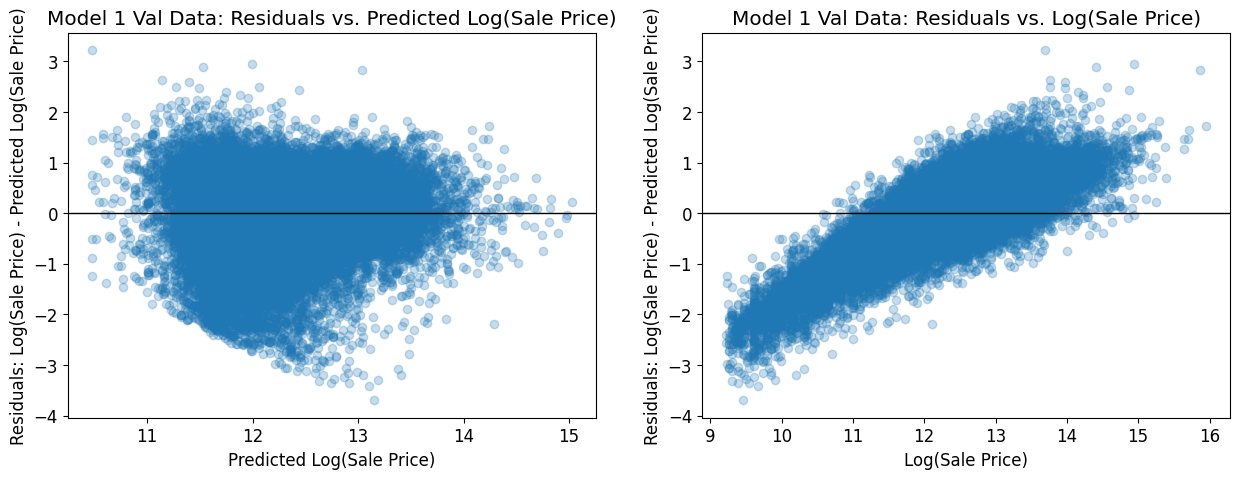

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))


x_plt1 = Y_predict_valid_m1
y_plt1 = Y_valid_m1 - Y_predict_valid_m1

x_plt2 = Y_valid_m1
y_plt2 = Y_valid_m1 - Y_predict_valid_m1



ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 1 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 1 Val Data: Residuals vs. Log(Sale Price)")

---

## Adding more features


In [20]:
# Just run this cell - it creates the columns of the 2 additional features we're interested in considering 
# and appends the residual data from Model 1, so we can easily visualize

from feature_func import *


def process_data_candidates(data):
    
    # Remove Non-Market Sales
    data = data[data["Pure Market Filter"]==1]
    
    data["Log Sale Price"] = np.log(data["Sale Price"])
    
    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])
    
    
    # Create Bedrooms
    data = add_total_bedrooms(data)
   
    # Update Roof Material feature with names
    data = substitute_roof_material(data)
    
    # Select columns for comparing residuals
    data = data[['Log Building Square Feet',  'Roof Material', 'Bedrooms', 'Log Sale Price']]

    return data


#Since our residuals are using the validation data, we will just examine these new features on the validation dataset
    
valid_comp = process_data_candidates(valid)
    
valid_comp = valid_comp.assign(M1residuals_log=Y_valid_m1 - Y_predict_valid_m1)


In [21]:
# Run this cell to compare residuals with Bedrooms

import plotly.express as px

px.box(valid_comp, x='Bedrooms', y='M1residuals_log')


Notice, the medians of each boxplot align pretty close to 0 on the y-axis (meaning there is no major trend in prediction errors by Number of Bedrooms).

This means we do NOT expect adding the features Bedrooms will help improve our original model.

What about Roof Material?


In [22]:
# Run this cell to compare residuals vs Roof Material

px.box(valid_comp, x='Roof Material', y='M1residuals_log')

The plot above shows us that the distribution of errors appears to change slightly based on Roof Material. Ideally, the median of each  box plot lines up with 0 on the y-axis (meaning there was no difference in prediction by Roof Material type). Instead, we see some variation from 0 for all except Shingle/Asphalt.   These patterns suggest that we may want to try including Roof Material in the model.


## Adding Roof Material to the Model

Model 2: 
$$
\text{Log Sale Price} =  \theta_1 (\text{Log Building Square Feet})  +\theta_2 (\text{Shingle/Asphalt})+ \theta_3 (\text{Tar\&Gravel})+ \theta_4  (\text{Tile})+ \theta_5 (\text{Shake})+  \theta_6(\text{Other})+  \theta_7(\text{Slate})
$$




In [23]:
# Modeling Step 1:  Process the Data

# Hint: You can either use your implementation of the One Hot Encoding Function from Project Part 1, or use the staff's implementation

from feature_func import *

def substitute_roof_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    copy_data = data.copy()
    roof_material_mapping = {
        1: 'Shingle/Asphalt',
        2: 'Tar&Gravel',
        3: 'Slate',
        4: 'Shake',
        5: 'Tile',
        6: 'Other'
    }
    copy_data['Roof Material'] = copy_data['Roof Material'].replace(roof_material_mapping)
    return copy_data

# def ohe_roof_material(data):
#     """
#     One-hot-encodes roof material.  New columns are of the form "Roof Material_MATERIAL"
#     """
#     data = data.copy()
#     ohe = OneHotEncoder()

#     ohe.fit(data[['Roof Material']])
    
#     ohe_data = ohe.transform(data[['Roof Material']]).toarray()
#     ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(['Roof Material']))

#     data_reset = data.reset_index(drop=True)
#     ohe_df_reset = ohe_df.reset_index(drop=True)
    
#     return pd.concat([data_reset, ohe_df_reset], axis=1)
# Optional:  Define any helper functions you need for one-hot encoding above this line


def process_data_m2(data):
    
    # You should start by only keeping values with Pure Market Filter = 1
    
    # Remove Non-Market Sales
    data = data[data["Pure Market Filter"]==1]

    # Create Log Sale Price column
    data["Log Sale Price"] = np.log(data["Sale Price"])

    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])

    # Change Roof Material to names
    data = substitute_roof_material(data)

    # one-hot encode the roof material
    data = ohe_roof_material(data)

    # select only relevant columns
    relevant_columns = ['Log Building Square Feet', 'Log Sale Price'] + [col for col in data.columns if "Roof Material_" in col] 
    data = data[relevant_columns]
    
    return data

    

# Use the same original train and valid datasets from 3a (otherwise the validation errors aren't comparable), 
# Don't resplit the data.  

# Process the data for Model 2
processed_train_m2 = process_data_m2(train)

processed_val_m2 = process_data_m2(valid)


# Create X (dataframe) and Y (series) to use in the model
X_train_m2 = processed_train_m2.drop(columns = ["Log Sale Price"])
Y_train_m2 = processed_train_m2["Log Sale Price"]

X_valid_m2 = processed_val_m2.drop(columns = ["Log Sale Price"])
Y_valid_m2 = processed_val_m2["Log Sale Price"]


# Take a look at the result
display(X_train_m2.head())
display(Y_train_m2.head())

display(X_valid_m2.head())
display(Y_valid_m2.head())


Log Building Square Feet  Roof Material_Other  Roof Material_Shake  \
130829                  7.870166                  0.0                  0.0   
193890                  7.002156                  0.0                  0.0   
30507                   6.851185                  0.0                  0.0   
91308                   7.228388                  0.0                  0.0   
131132                  7.990915                  0.0                  0.0   

        Roof Material_Shingle/Asphalt  Roof Material_Slate  \
130829                            1.0                  0.0   
193890                            1.0                  0.0   
30507                             1.0                  0.0   
91308                             1.0                  0.0   
131132                            1.0                  0.0   

        Roof Material_Tar&Gravel  Roof Material_Tile  
130829                       0.0                 0.0  
193890                       0.0                 0.0  
30507                        0.0                 0.0  
91308                        0.0                 0.0  
131132                       0.0                 0.0

130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

Log Building Square Feet  Roof Material_Other  Roof Material_Shake  \
50636                   7.310550                  0.0                  0.0   
82485                   7.325808                  0.0                  0.0   
193966                  7.090077                  0.0                  0.0   
160612                  7.281386                  0.0                  0.0   
7028                    7.118016                  0.0                  0.0   

        Roof Material_Shingle/Asphalt  Roof Material_Slate  \
50636                             1.0                  0.0   
82485                             1.0                  0.0   
193966                            1.0                  0.0   
160612                            1.0                  0.0   
7028                              1.0                  0.0   

        Roof Material_Tar&Gravel  Roof Material_Tile  
50636                        0.0                 0.0  
82485                        0.0                 0.0  
193966                       0.0                 0.0  
160612                       0.0                 0.0  
7028                         0.0                 0.0

50636     11.682668
82485     12.820655
193966     9.825526
160612    12.468437
7028      12.254863
Name: Log Sale Price, dtype: float64

In [24]:
# Modeling STEP 2:  Create a Multiple Linear Regression Model

# Be sure to set fit_intercept to False, since we are incorporating one-hot-encoded data

linear_model_m2 = lm.LinearRegression(fit_intercept=False)

# Fit the model using the processed training data
linear_model_m2.fit(X_train_m2, Y_train_m2)

# your code above this line to create regression model for Model 2

Y_predict_train_m2 = linear_model_m2.predict(X_train_m2)
Y_predict_valid_m2 = linear_model_m2.predict(X_valid_m2)




In [25]:
# MODELING STEP 3:  Evaluate the RMSE for your model

# Training and test errors for the model (in its units of Log Sale Price)

training_error_log[1] = rmse(Y_predict_train_m2, Y_train_m2)
validation_error_log[1]= rmse(Y_predict_valid_m2, Y_valid_m2)

# Training and test errors for the model (in its original values before the log transform)
training_error[1] = rmse(np.exp(Y_predict_train_m2), np.exp(Y_train_m2))
validation_error[1] = rmse(np.exp(Y_predict_valid_m2), np.exp(Y_valid_m2))


print("2nd Model\nTraining RMSE (log): {}\nValidation RMSE (log): {}\n".format(training_error_log[1], validation_error_log[1]))
print("2nd Model \nTraining RMSE: {}\nValidation RMSE: {}\n".format(training_error[1], validation_error[1]))


2nd Model
Training RMSE (log): 0.748380262137429
Validation RMSE (log): 0.748019915798402

2nd Model 
Training RMSE: 242236.36744021266
Validation RMSE: 247381.6124036663



In [26]:
# MODELING STEP 4:  Conduct 5-fold cross validation for model and output RMSE

# Create a new model to fit on the whole training_val dataset
linear_model_m2_cv = lm.LinearRegression(fit_intercept=False)

# Process the entire training_val dataset using the pipeline
processed_full_m2 = process_data_m2(training_val_data)

# Split into X and Y:
X_full_m2 = processed_full_m2.drop(columns = "Log Sale Price")
Y_full_m2 = processed_full_m2["Log Sale Price"]

cv_error[1] = cross_validate_rmse(linear_model_m2_cv, X_full_m2, Y_full_m2)

# your code above this line to use 5-fold cross-validation and output RMSE (in units of dollars)

cv_error[1] = cross_validate_rmse(linear_model_m2, X_full_m2, Y_full_m2)

print("2nd Model Cross Validation RMSE: {}".format(cv_error[1]))



2nd Model Cross Validation RMSE: 243124.9735887618


In [27]:
# MODELING STEP 5:  Just run this cell to Plot bar graph comparing RMSEs of Model 2 and Model 1 and side-by-side residuals

model_names[1] = "M2: log(bsqft)+Roof"

fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig


Text(0.5, 1.0, 'Model 2 Val Data: Residuals vs. Log(Sale Price)')

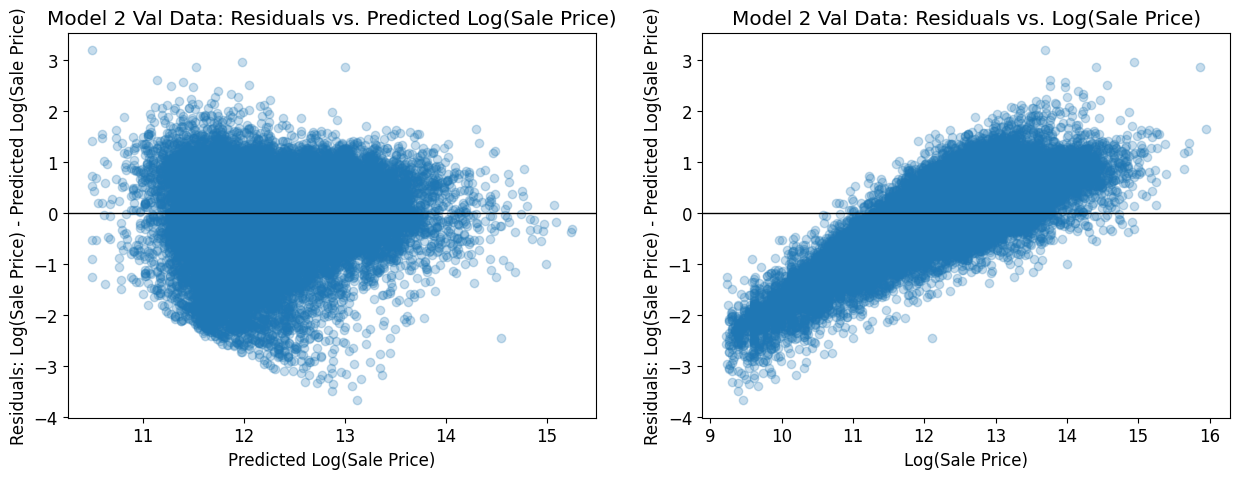

In [28]:
# MODELING STEP 5 cont'd:  Plot 2 side-by-side residual plots (similar to Question 3, for validation data)

fig, ax = plt.subplots(1,2, figsize=(15, 5))


x_plt1 = Y_predict_valid_m2
y_plt1 = Y_valid_m2 - Y_predict_valid_m2

x_plt2 = Y_valid_m2
y_plt2 = Y_valid_m2 - Y_predict_valid_m2


ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 2 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 2 Val Data: Residuals vs. Log(Sale Price)")



## Further Improving the Model

### More EDA

In [31]:
training_val_data['Town Code'].unique()

array([76, 71, 70, 17, 32, 72, 37, 25, 29, 31, 38, 35, 18, 22, 28, 34, 36,
       23, 24, 19, 16, 73, 20, 21, 39, 12, 13, 77, 27, 74, 11, 10, 33, 15,
       75, 30, 26, 14])

In [32]:
training_val_data['Road Proximity'].value_counts()

# Show work in this cell exploring data to determine which feature to add

0.0    190453
1.0     14339
Name: Road Proximity, dtype: int64

count    204792.000000
mean          6.598121
std           2.900149
min           0.100000
25%           5.100000
50%           6.200000
75%           8.900000
max          17.200000
Name: Age Decade, dtype: float64

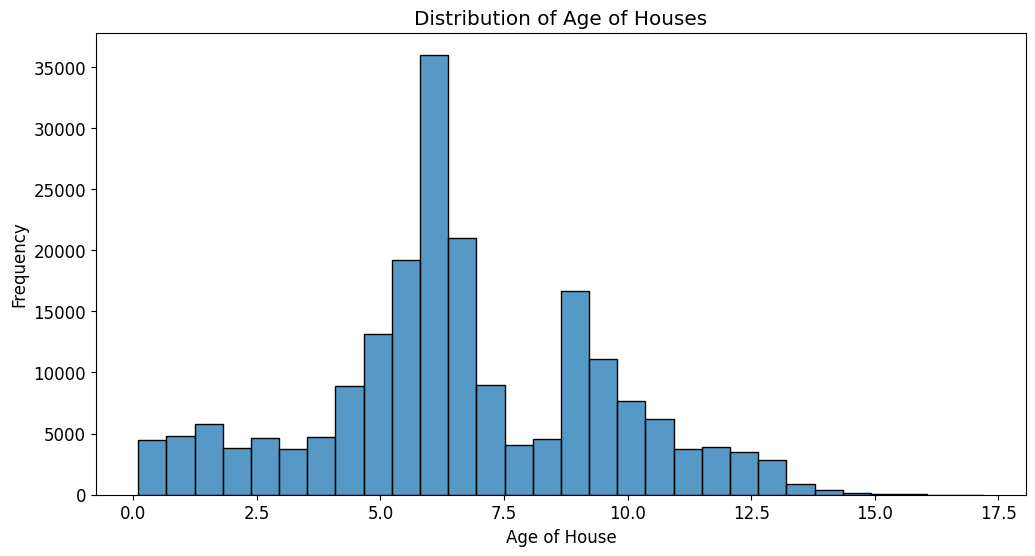

Correlation between log of Age Decade and log of Sale Price: -0.12525287157471637


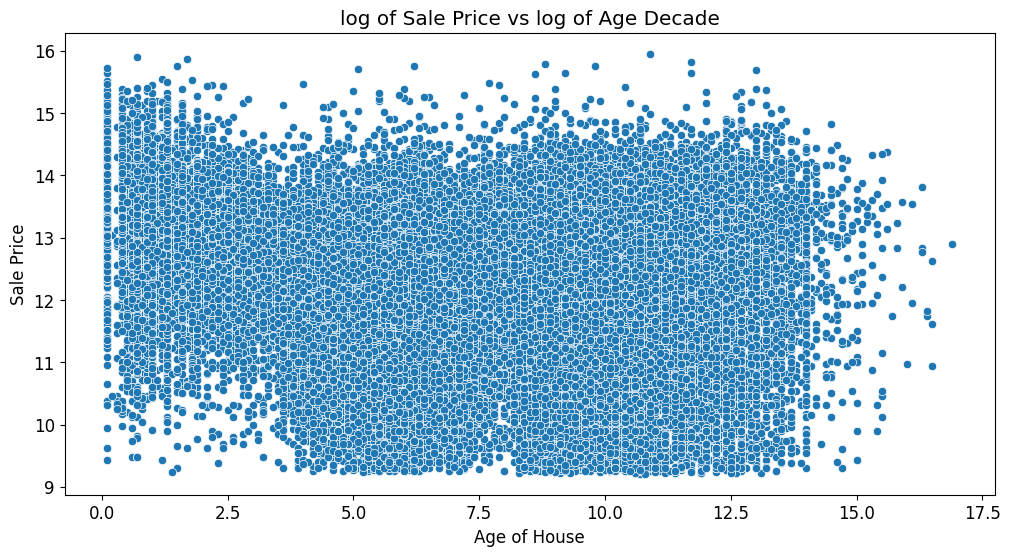

In [34]:
display(training_val_data['Age Decade'].describe())

# visualising the distribution of the age of the houses
plt.figure(figsize=(12, 6))
sns.histplot(training_val_data['Age Decade'], bins=30)
plt.title("Distribution of Age of Houses")
plt.xlabel("Age of House")
plt.ylabel("Frequency")
plt.show()

# finding the correlation between log Age Decade and log Sale Price
log_age_decade = np.log(training_val_data['Age Decade'])
log_sale_price = np.log(training_val_data['Sale Price'])
correlation = log_age_decade.corr(log_sale_price)
print(f"Correlation between log of Age Decade and log of Sale Price: {correlation}")


plt.figure(figsize=(12, 6))
sns.scatterplot(x=np.log(training_val_data[training_val_data['Pure Market Filter'] == 1]['Age Decade']), y=np.log(training_val_data[training_val_data['Pure Market Filter'] == 1]['Sale Price']))
plt.title("log of Sale Price vs log of Age Decade")
plt.xlabel("Age of House")
plt.ylabel("Sale Price")
plt.show()

# Optional code cell for additional work exploring data/ explaining which feature you chose.

1235

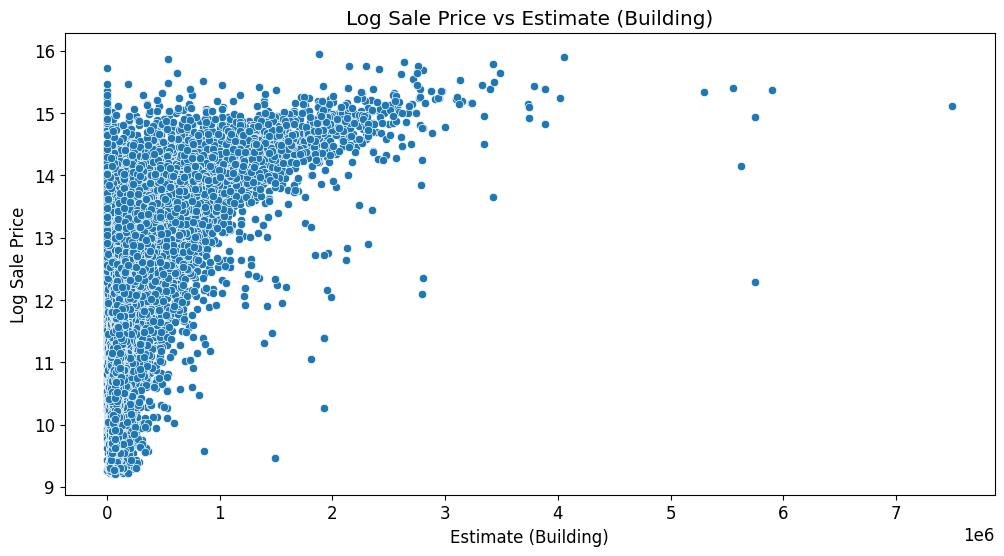

Correlation between Estimate (Building) and Sale Price:  0.6092859158684686


In [375]:
display(sum(training_val_data[training_val_data['Pure Market Filter'] == 1]['Estimate (Building)'] == 0))

plt.figure(figsize=(12, 6))
sns.scatterplot(x=training_val_data[training_val_data['Pure Market Filter'] == 1]['Estimate (Building)'], y=np.log(training_val_data[training_val_data['Pure Market Filter'] == 1]['Sale Price']))
plt.title("Log Sale Price vs Estimate (Building)")
plt.xlabel("Estimate (Building)")
plt.ylabel("Log Sale Price")
plt.show()


print("Correlation between Estimate (Building) and Sale Price: ", training_val_data['Estimate (Building)'].corr(training_val_data['Sale Price']))

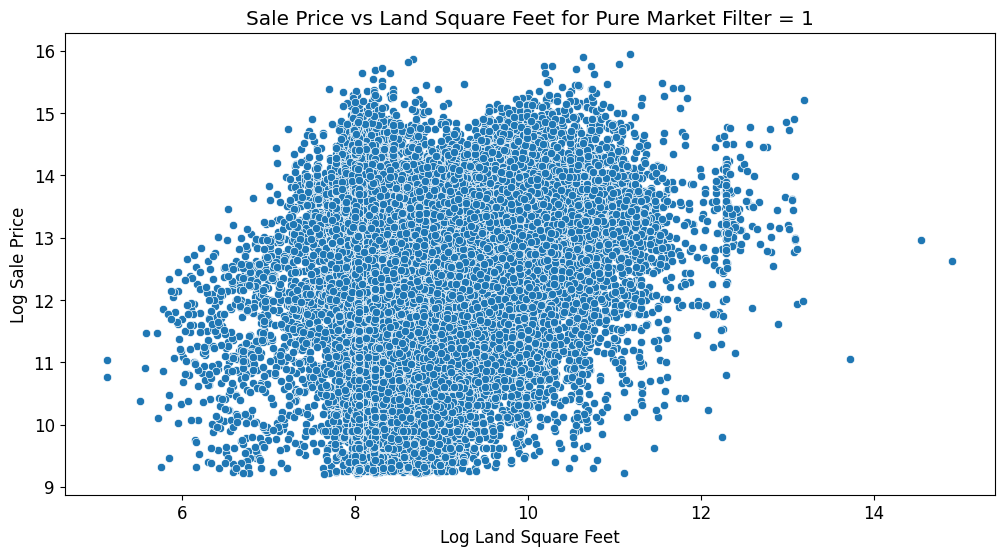

Correlation between log of Land Square Feet and log of Sale Price: 0.2578511813965192


In [376]:
# scatter plot land square feet vs sale price

plt.figure(figsize=(12, 6))
filtered_data = training_val_data[training_val_data['Pure Market Filter'] == 1]
sns.scatterplot(x=np.log(filtered_data['Land Square Feet']), y=np.log(filtered_data['Sale Price']))
plt.title("Sale Price vs Land Square Feet for Pure Market Filter = 1")
plt.xlabel("Log Land Square Feet")
plt.ylabel("Log Sale Price")
plt.show()

# finding correlation

log_land_sqft = np.log(filtered_data['Land Square Feet'])
correlation = log_land_sqft.corr(log_sale_price)
print(f"Correlation between log of Land Square Feet and log of Sale Price: {correlation}")



In [36]:


def process_data_candidates(data):
    data = data[data["Pure Market Filter"]==1]

    data["Log Sale Price"] = np.log(data["Sale Price"])

    data = data[['Town Code', 'Log Sale Price']]

    return data

valid_comp = process_data_candidates(valid)

valid_comp = valid_comp.assign(M2residuals_log=Y_valid_m2 - Y_predict_valid_m2)


In [37]:
px.box(valid_comp, x='Town Code', y='M2residuals_log')

<!-- END QUESTION -->

### Creating another model

<!-- BEGIN QUESTION -->



In [40]:
# Modeling Step 1:  Process the Data

# Hint: You can either use your implementation of the One Hot Encoding Function 
#from Project Part 1, or use the staff's implementation

from feature_func import *


# Optional:  Define any helper functions you need for one-hot encoding above this line
def ohe_town_code(data):
    oh_enc = OneHotEncoder()
    oh_enc.fit(data[['Town Code']])
    dummies = pd.DataFrame(
        oh_enc.transform(data[['Town Code']]).todense(), 
        columns=oh_enc.get_feature_names_out(),
        index = data.index
    )
    return data.join(dummies)

def process_data_m3(data):
    
    # You should start by only keeping values with Pure Market Filter = 1
    
    # Remove Non-Market Sales
    data = data[data["Pure Market Filter"]==1]

    # Create Log Sale Price column
    data["Log Sale Price"] = np.log(data["Sale Price"])

    # Create Log Building Square Feet column
    data["Log Building Square Feet"] = np.log(data["Building Square Feet"])

    # Create Log Estimate (Building) column
    data["Log Estimate (Building)"] = np.log(data["Estimate (Building)"] + 1)

    # One hot encode the town code
    data = ohe_town_code(data)

    # select only relevant columns
    relevant_columns = ['Log Estimate (Building)', 'Log Building Square Feet', 'Log Sale Price'] + [col for col in data.columns if "Town Code_" in col]
    data = data[relevant_columns]


    
    return data

    
# Use the same original train and valid datasets from 3a 
#(otherwise the validation errors aren't comparable), 
# Don't resplit the data.  


# Process the data for Model 3
processed_train_m3 = process_data_m3(train)

processed_val_m3 = process_data_m3(valid)

# Create X (Dataframe) and Y (series) to use to train the model
X_train_m3 = processed_train_m3.drop(columns = ["Log Sale Price"])
Y_train_m3 = processed_train_m3["Log Sale Price"]

X_valid_m3 = processed_val_m3.drop(columns = ["Log Sale Price"])
Y_valid_m3 = processed_val_m3["Log Sale Price"]


# Take a look at the result
display(X_train_m3.head())
display(Y_train_m3.head())

display(X_valid_m3.head())
display(Y_valid_m3.head())

Log Estimate (Building)  Log Building Square Feet  Town Code_10  \
130829                13.019934                  7.870166           0.0   
193890                10.969766                  7.002156           0.0   
30507                 11.569599                  6.851185           0.0   
91308                 12.839685                  7.228388           0.0   
131132                12.357553                  7.990915           0.0   

        Town Code_11  Town Code_12  Town Code_13  Town Code_14  Town Code_15  \
130829           0.0           0.0           0.0           0.0           0.0   
193890           0.0           0.0           0.0           0.0           0.0   
30507            0.0           0.0           0.0           0.0           0.0   
91308            0.0           0.0           0.0           0.0           0.0   
131132           0.0           0.0           1.0           0.0           0.0   

        Town Code_16  Town Code_17  ...  Town Code_38  Town Code_39  \
130829           0.0           0.0  ...           1.0           0.0   
193890           0.0           0.0  ...           0.0           0.0   
30507            0.0           0.0  ...           0.0           0.0   
91308            0.0           0.0  ...           0.0           0.0   
131132           0.0           0.0  ...           0.0           0.0   

        Town Code_70  Town Code_71  Town Code_72  Town Code_73  Town Code_74  \
130829           0.0           0.0           0.0           0.0           0.0   
193890           0.0           0.0           1.0           0.0           0.0   
30507            0.0           0.0           0.0           0.0           0.0   
91308            0.0           0.0           0.0           0.0           0.0   
131132           0.0           0.0           0.0           0.0           0.0   

        Town Code_75  Town Code_76  Town Code_77  
130829           0.0           0.0           0.0  
193890           0.0           0.0           0.0  
30507            0.0           0.0           0.0  
91308            0.0           0.0           1.0  
131132           0.0           0.0           0.0  

[5 rows x 40 columns]

130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

Log Estimate (Building)  Log Building Square Feet  Town Code_10  \
50636                 11.669767                  7.310550           0.0   
82485                 12.264676                  7.325808           0.0   
193966                10.669908                  7.090077           0.0   
160612                12.154100                  7.281386           0.0   
7028                  11.355581                  7.118016           0.0   

        Town Code_11  Town Code_12  Town Code_13  Town Code_14  Town Code_15  \
50636            0.0           0.0           0.0           0.0           0.0   
82485            0.0           0.0           0.0           0.0           0.0   
193966           0.0           0.0           0.0           0.0           0.0   
160612           0.0           0.0           0.0           0.0           0.0   
7028             0.0           0.0           0.0           0.0           1.0   

        Town Code_16  Town Code_17  ...  Town Code_38  Town Code_39  \
50636            0.0           0.0  ...           0.0           0.0   
82485            0.0           0.0  ...           0.0           0.0   
193966           0.0           0.0  ...           0.0           0.0   
160612           0.0           0.0  ...           0.0           0.0   
7028             0.0           0.0  ...           0.0           0.0   

        Town Code_70  Town Code_71  Town Code_72  Town Code_73  Town Code_74  \
50636            0.0           0.0           0.0           0.0           0.0   
82485            0.0           0.0           1.0           0.0           0.0   
193966           0.0           0.0           0.0           0.0           0.0   
160612           0.0           0.0           0.0           0.0           0.0   
7028             0.0           0.0           0.0           0.0           0.0   

        Town Code_75  Town Code_76  Town Code_77  
50636            0.0           0.0           1.0  
82485            0.0           0.0           0.0  
193966           0.0           0.0           0.0  
160612           0.0           0.0           0.0  
7028             0.0           0.0           0.0  

[5 rows x 40 columns]

50636     11.682668
82485     12.820655
193966     9.825526
160612    12.468437
7028      12.254863
Name: Log Sale Price, dtype: float64

In [41]:
# Modeling STEP 2:  Create a Multiple Linear Regression Model

# Be sure to set fit_intercept to False, since we are incorporating one-hot-encoded data
linear_model_m3 = lm.LinearRegression(fit_intercept=False)

# Fit the model using the processed training data
linear_model_m3.fit(X_train_m3, Y_train_m3)
# your code above this line to create regression model for Model 2

Y_predict_train_m3 = linear_model_m3.predict(X_train_m3)

Y_predict_valid_m3 = linear_model_m3.predict(X_valid_m3)




In [42]:
# MODELING STEP 3:  Evaluate the RMSE for your model

# Training and test errors for the model (in its units of Log Sale Price)

training_error_log[2] = rmse(Y_predict_train_m3, Y_train_m3)
validation_error_log[2]= rmse(Y_predict_valid_m3, Y_valid_m3)

# Training and test errors for the model (in its original values before the log transform)
training_error[2] = rmse(np.exp(Y_predict_train_m3), np.exp(Y_train_m3))
validation_error[2] = rmse(np.exp(Y_predict_valid_m3), np.exp(Y_valid_m3))


(print("3rd Model\nTraining RMSE (log): {}\nValidation RMSE (log): {}\n"
      .format(training_error_log[2], validation_error_log[2]))
)

(print("3rd Model \nTraining RMSE: {}\nValidation RMSE: {}\n"
       .format(training_error[2], validation_error[2]))
)


3rd Model
Training RMSE (log): 0.565846627732036
Validation RMSE (log): 0.5633294958990946

3rd Model 
Training RMSE: 174938.79104247678
Validation RMSE: 180518.9011779478



In [43]:
# MODELING STEP 4:  Conduct 5-fold cross validation for model and output RMSE

# Create a new model to fit on the whole training_val dataset
linear_model_m3_cv = lm.LinearRegression(fit_intercept=False)

# Process the entire training_val dataset using the pipeline
processed_full_m3 = process_data_m3(training_val_data)

# Split into X and Y:
X_full_m3 = processed_full_m3.drop(columns = "Log Sale Price")
Y_full_m3 = processed_full_m3["Log Sale Price"]

cv_error[2] = cross_validate_rmse(linear_model_m3_cv, X_full_m3, Y_full_m3)

# your code above this line to use 5-fold cross-validation and 
#output RMSE (in units of dollars)

cv_error[2] = cross_validate_rmse(linear_model_m3, X_full_m3, Y_full_m3)

print("3rd Model Cross Validation RMSE: {}".format(cv_error[2]))



3rd Model Cross Validation RMSE: 176093.7881195555


In [44]:
# MODELING STEP 5:  Add a name for your 3rd model describing the features 
#and run this cell to Plot bar graph all 3 models

model_names[2] = "M3: log(bsqft)+log(est_bldg)+Roof"


fig = go.Figure([
go.Bar(x = model_names, y = training_error, name="Training RMSE"),
go.Bar(x = model_names, y = validation_error, name="Validation RMSE"),
go.Bar(x = model_names, y = cv_error, name="Cross Val RMSE")
])

fig.update_yaxes(range=[180000,260000], title="RMSE")

fig


Text(0.5, 1.0, 'Model 3 Val Data: Residuals vs. Log(Sale Price)')

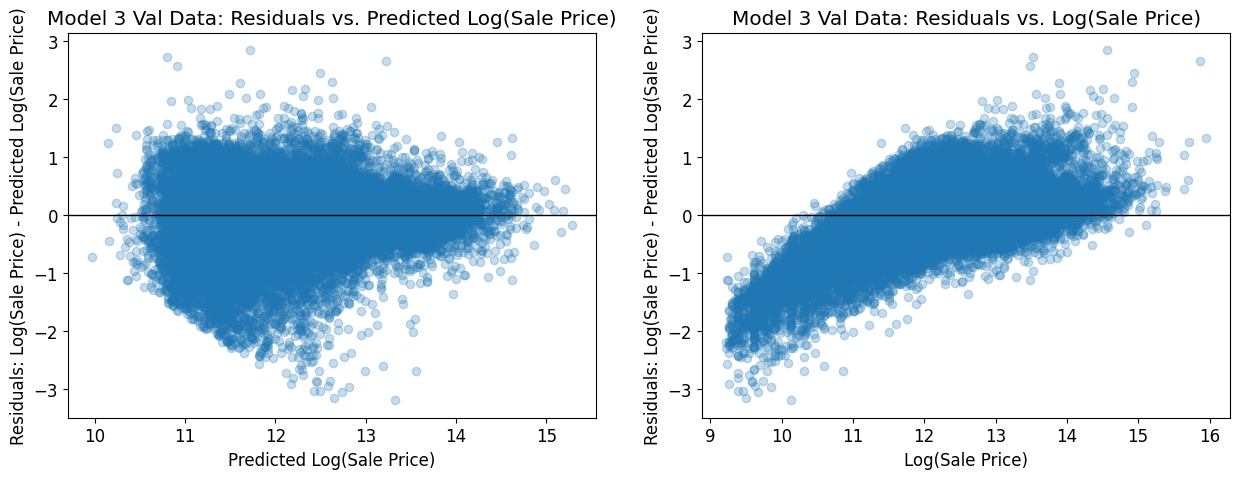

In [45]:
# MODELING STEP 5 cont'd:  Plot 2 side-by-side residual plots 
#(similar to Question 3, for validation data)

fig, ax = plt.subplots(1,2, figsize=(15, 5))


x_plt1 = Y_predict_valid_m3
y_plt1 = Y_valid_m3 - Y_predict_valid_m3

x_plt2 = Y_valid_m3
y_plt2 = Y_valid_m3 - Y_predict_valid_m3


ax[0].scatter(x_plt1, y_plt1, alpha=.25)
ax[0].axhline(0, c='black', linewidth=1)
ax[0].set_xlabel(r'Predicted Log(Sale Price)')
ax[0].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[0].set_title("Model 3 Val Data: Residuals vs. Predicted Log(Sale Price)")

ax[1].scatter(x_plt2, y_plt2, alpha=.25)
ax[1].axhline(0, c='black', linewidth=1)
ax[1].set_xlabel(r'Log(Sale Price)')
ax[1].set_ylabel(r'Residuals: Log(Sale Price) - Predicted Log(Sale Price)');
ax[1].set_title("Model 3 Val Data: Residuals vs. Log(Sale Price)")
